In [1]:
import pandas as pd
import numpy as np

In [2]:
inputDir = "../../input/m5-forecasting-accuracy/"
calendar_df = pd.read_csv(inputDir + 'calendar.csv')
train_df = pd.read_csv(inputDir +'sales_train_validation.csv')
prices_df = pd.read_csv(inputDir + 'sell_prices.csv')

In [3]:
good_id = 334
this_store = train_df.loc[good_id, "store_id"]
this_good = train_df.loc[good_id, "item_id"]

In [4]:
selected_price_df = prices_df[prices_df["store_id"] == this_store]
selected_price_df = selected_price_df[selected_price_df["item_id"] == this_good]
selected_price_df.head()

,store_id,item_id,wm_yr_wk,sell_price
77569,CA_1,HOBBIES_1_343,11101,4.78
77570,CA_1,HOBBIES_1_343,11102,4.78
77571,CA_1,HOBBIES_1_343,11103,4.78
77572,CA_1,HOBBIES_1_343,11104,4.78
77573,CA_1,HOBBIES_1_343,11105,4.78


In [5]:
# %%timeit
tmp_calendar_df = calendar_df.copy()
event_type = ["Cultural", "National", "Religious", "Sporting"]

tmp_calendar_df["Cultural_forward"] = 0
tmp_calendar_df["Cultural_back"] = 0
tmp_calendar_df["National_forward"] = 0
tmp_calendar_df["National_back"] = 0
tmp_calendar_df["Religious_forward"] = 0
tmp_calendar_df["Religious_back"] = 0
tmp_calendar_df["Sporting_forward"] = 0
tmp_calendar_df["Sporting_back"] = 0

forward = [event_type[i] + "_forward" for i in range(4)]
back = [event_type[i] + "_back" for i in range(4)]
now_score = [0 for i in range(4)]
for day in range(tmp_calendar_df.shape[0]):
    for i in range(4):
        if tmp_calendar_df.event_type_1.values[day] == event_type[i]:
            now_score[i] = 1
        if tmp_calendar_df.event_type_2.values[day] == event_type[i]:
            now_score[i] = 1
    
    for i in range(4):
        tmp_calendar_df.loc[day, forward[i]] = now_score[i]
        now_score[i] /= 2
        if now_score[i] < 0.1:
            now_score[i] = 0
            
now_score = [0 for i in range(4)]
for day in reversed(range(tmp_calendar_df.shape[0])):
    for i in range(4):
        if tmp_calendar_df.event_type_1.values[day] == event_type[i]:
            now_score[i] = 1
        if tmp_calendar_df.event_type_2.values[day] == event_type[i]:
            now_score[i] = 1
    
    for i in range(4):
        tmp_calendar_df.loc[day, back[i]] = now_score[i]
        now_score[i] /= 2
        if now_score[i] < 0.1:
            now_score[i] = 0

tmp_calendar_df = tmp_calendar_df.drop(columns=["date", "weekday", "event_type_1", "event_type_2", "event_name_1", "event_name_2"])
print(tmp_calendar_df.shape)
tmp_calendar_df.to_csv('tmp.csv', index=False)
tmp_calendar_df.head()

(1969, 16)


,wm_yr_wk,wday,month,year,d,snap_CA,snap_TX,snap_WI,Cultural_forward,Cultural_back,National_forward,National_back,Religious_forward,Religious_back,Sporting_forward,Sporting_back
0,11101,1,1,2011,d_1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11101,2,1,2011,d_2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11101,3,1,2011,d_3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11101,4,2,2011,d_4,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11101,5,2,2011,d_5,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
tmp_calendar_df = pd.merge(tmp_calendar_df, selected_price_df)
tmp_calendar_df.index = tmp_calendar_df["d"]
tmp_calendar_df = tmp_calendar_df.drop(columns=["d", "store_id", "item_id"])
print(tmp_calendar_df.shape)

(1969, 16)


In [7]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

start_day = tmp_calendar_df.index[0]
end_day = "d_1913"
data_x = tmp_calendar_df.loc[start_day:end_day, :]
print(data_x.shape)
print(start_day, end_day)
data_x.head()

(1913, 16)
d_1 d_1913


,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,Cultural_forward,Cultural_back,National_forward,National_back,Religious_forward,Religious_back,Sporting_forward,Sporting_back,sell_price
d,,,,,,,,,,,,,,,,
d_1,11101,1,1,2011,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.78
d_2,11101,2,1,2011,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.78
d_3,11101,3,1,2011,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.78
d_4,11101,4,2,2011,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.78
d_5,11101,5,2,2011,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.78


In [8]:
data_y = train_df.loc[7, start_day:end_day].T.astype('float')
print(data_y.shape)
print(data_y.dtypes)
data_y.head()

(1913,)
float64


d_1    12.0
d_2    15.0
d_3     0.0
d_4     0.0
d_5     0.0
Name: 7, dtype: float64

In [9]:
train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size=0.33, random_state=0)

lgbm_params = {'objective': 'binary'}
lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(valid_x, valid_y)
evals_result = {}

In [10]:
gbm = lgb.train(params=lgbm_params,
                train_set=lgb_train, 
                valid_sets=[lgb_train, lgb_eval], 
                early_stopping_rounds=20, 
                evals_result=evals_result, 
                verbose_eval=10);

Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.396293	valid_1's binary_logloss: 0.442587
[20]	training's binary_logloss: 0.33098	valid_1's binary_logloss: 0.416511
[30]	training's binary_logloss: 0.292041	valid_1's binary_logloss: 0.404486
[40]	training's binary_logloss: 0.260529	valid_1's binary_logloss: 0.404922
[50]	training's binary_logloss: 0.239316	valid_1's binary_logloss: 0.410165
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.285416	valid_1's binary_logloss: 0.403225


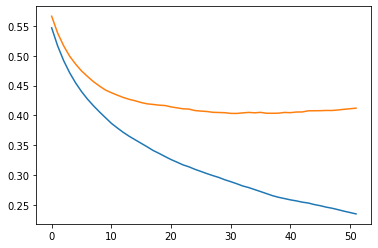

In [11]:
import matplotlib.pyplot as plt

plt.plot(evals_result['training']['binary_logloss'], label='train_loss') 
plt.plot(evals_result['valid_1']['binary_logloss'], label='valid_loss')